<a href="https://colab.research.google.com/github/SharlotteManganye/Deep-Learning-CNN/blob/main/CNN%2C_PI_CNN_and_PI_SIGMA_CNN_Feature_ExtractionV1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt


Visualize feature maps on a simple **CNN**

In [3]:

# Load the MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
mnist_data = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
data_loader = torch.utils.data.DataLoader(mnist_data, batch_size=1, shuffle=True)


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.5MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 443kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.08MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.52MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Visualize feature maps on a simple **CNN**

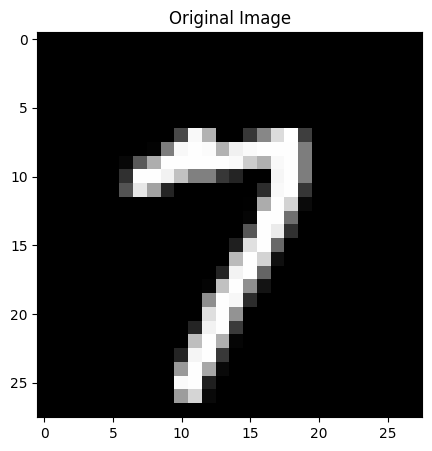

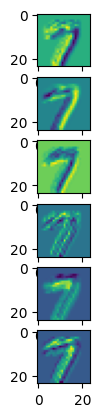

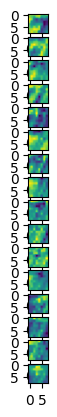

In [14]:
# Load the MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
mnist_data = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
data_loader = torch.utils.data.DataLoader(mnist_data, batch_size=1, shuffle=True)

# Define the CNN model
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = CNNModel()

# Register forward hooks
activation = {}

def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

model.conv1.register_forward_hook(get_activation('conv1'))
model.conv2.register_forward_hook(get_activation('conv2'))

# Pass an image through the model
data_iter = iter(data_loader)
images, labels = next(data_iter)  # Use next() function
output = model(images)

# Visualize the original image
plt.figure(figsize=(5, 5))
plt.imshow(images[0][0], cmap='gray')
plt.title('Original Image')
plt.show()

# Visualize the feature maps
def plot_activation(activation, layer_name):
    act = activation[layer_name].squeeze()
    fig, axarr = plt.subplots(act.size(0))
    for idx in range(act.size(0)):
        axarr[idx].imshow(act[idx])
    plt.show()

plot_activation(activation, 'conv1')
plot_activation(activation, 'conv2')

Visualize feature maps on a simple **PI-CNN**

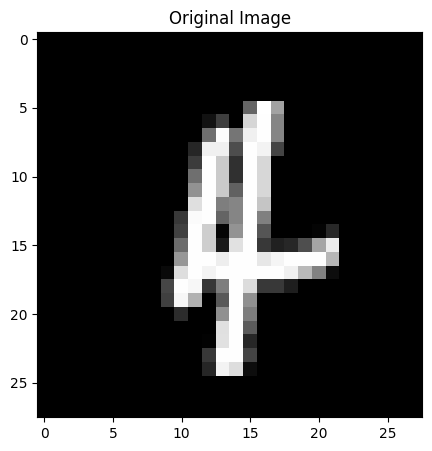

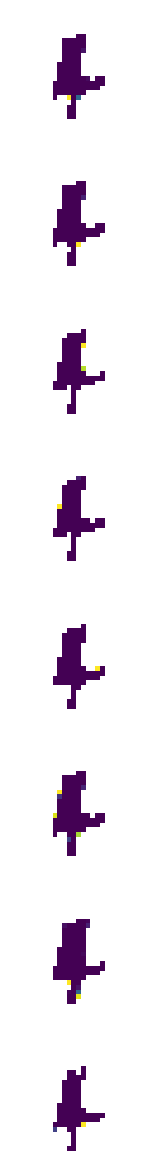

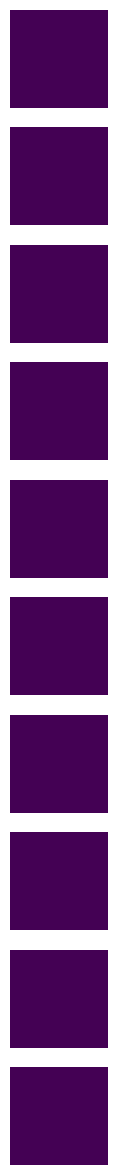

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
import math

# Define the ProductConv2d class
class ProductConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1):
        super(ProductConv2d, self).__init__()
        self.weights = nn.Parameter(torch.Tensor(out_channels, in_channels, kernel_size, kernel_size))
        self.stride = stride
        nn.init.kaiming_uniform_(self.weights, a=math.sqrt(5))

    def forward(self, x):
        unfolded = F.unfold(x, kernel_size=self.weights.shape[2:], stride=self.stride)
        unfolded = unfolded.view(x.size(0), x.size(1) * self.weights.shape[2] * self.weights.shape[3], -1)
        log_unfolded = torch.log(torch.abs(unfolded) + 1e-10)  # Add epsilon to avoid log(0)
        log_weights = torch.log(torch.abs(self.weights) + 1e-10).view(self.weights.size(0), -1)  # Add epsilon to avoid log(0)
        log_product = torch.matmul(log_weights, log_unfolded)
        return torch.exp(log_product).view(x.size(0), self.weights.size(0), x.size(2) - self.weights.shape[2] + 1, x.size(3) - self.weights.shape[3] + 1)

# Define the CombinedCNN class
class CombinedCNN(nn.Module):
    def __init__(self):
        super(CombinedCNN, self).__init__()
        self.product_conv1 = ProductConv2d(1, 8, kernel_size=3)
        self.product_conv2 = ProductConv2d(8, 10, kernel_size=3)
        self.fc1 = nn.Linear(10 * 5 * 5, 120)  # Adjusted input size for fully connected layer
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.product_conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)

        x = self.product_conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)

        x = x.view(-1, 10 * 5 * 5)  # Adjusted input size for fully connected layer
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

# Register forward hooks
activation = {}

def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

model = CombinedCNN()
model.eval()

model.product_conv1.register_forward_hook(get_activation('product_conv1'))
model.product_conv2.register_forward_hook(get_activation('product_conv2'))

# Load the MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
mnist_data = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
data_loader = torch.utils.data.DataLoader(mnist_data, batch_size=1, shuffle=True)

# Get a batch of data
data_iter = iter(data_loader)
images, labels = next(data_iter)

# Forward pass
output = model(images)

# Visualize the original image
plt.figure(figsize=(5, 5))
plt.imshow(images[0][0], cmap='gray')
plt.title('Original Image')
plt.show()

# Function to visualize the feature maps
def plot_activation(activation, layer_name):
    act = activation[layer_name].squeeze()
    fig, axarr = plt.subplots(act.size(0), figsize=(15, 15))
    for idx in range(act.size(0)):
        axarr[idx].imshow(act[idx], cmap='viridis')
        axarr[idx].axis('off')
    plt.show()

# Visualize the feature maps
plot_activation(activation, 'product_conv1')
plot_activation(activation, 'product_conv2')


Error: Unable to load image at path_to_your_image.jpg


Visualize feature maps on a simple *** PI-Sigma-CNN***

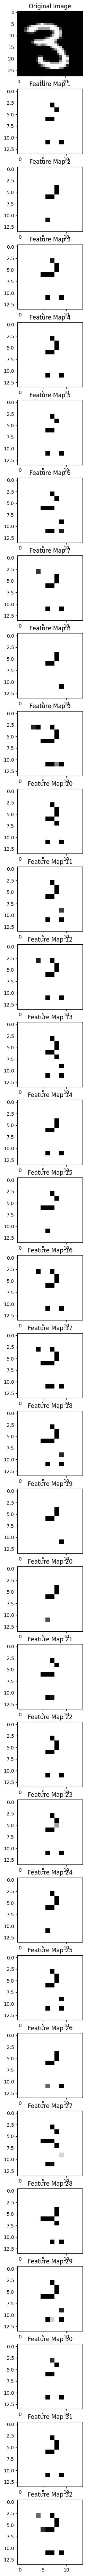

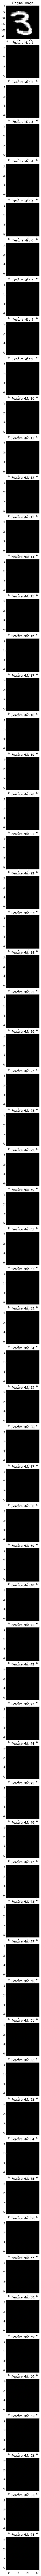

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import math

# Define the Product Unit Convolutional Layer
class ProductConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        super(ProductConv2d, self).__init__()
        self.weights = nn.Parameter(torch.Tensor(out_channels, in_channels, kernel_size, kernel_size))
        nn.init.kaiming_uniform_(self.weights, a=math.sqrt(5))

    def forward(self, x):
        unfolded = F.unfold(x, kernel_size=self.weights.shape[2:], stride=1, padding=self.weights.shape[2]//2)
        unfolded = unfolded.view(x.size(0), x.size(1) * self.weights.shape[2] * self.weights.shape[3], -1)
        log_unfolded = torch.log(torch.abs(unfolded) + 1e-10)
        log_weights = torch.log(torch.abs(self.weights) + 1e-10).view(self.weights.size(0), -1)
        log_product = torch.matmul(log_weights, log_unfolded)
        return torch.exp(log_product).view(x.size(0), self.weights.size(0), x.size(2), x.size(3))

class ProductCNN(nn.Module):
    def __init__(self):
        super(ProductCNN, self).__init__()
        self.conv1 = ProductConv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = ProductConv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        conv1_feature_maps = x.detach()

        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        conv2_feature_maps = x.detach()

        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x, conv1_feature_maps, conv2_feature_maps

# Load the MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
mnist_data = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
data_loader = torch.utils.data.DataLoader(mnist_data, batch_size=1, shuffle=True)

# Initialize the model and set it to evaluation mode
model = ProductCNN()
model.eval()

# Get a batch of images from the data loader
data_iter = iter(data_loader)
images, labels = next(data_iter)

# Pass an image through the model to get feature maps
output, conv1_feature_maps, conv2_feature_maps = model(images)

# Visualize the original image and feature maps
def plot_activation(feature_maps, original_image):
    num_feature_maps = feature_maps.size(1)
    fig, axarr = plt.subplots(num_feature_maps + 1, figsize=(15, num_feature_maps * 3))
    axarr[0].imshow(original_image.squeeze(), cmap='gray')
    axarr[0].set_title('Original Image')
    for idx in range(num_feature_maps):
        axarr[idx + 1].imshow(feature_maps[0, idx].detach().numpy(), cmap='gray')
        axarr[idx + 1].set_title(f'Feature Map {idx + 1}')
    plt.show()

plot_activation(conv1_feature_maps, images[0])
plot_activation(conv2_feature_maps, images[0])


Visualize feature maps on a simple *** PI-Sigma-CNN***

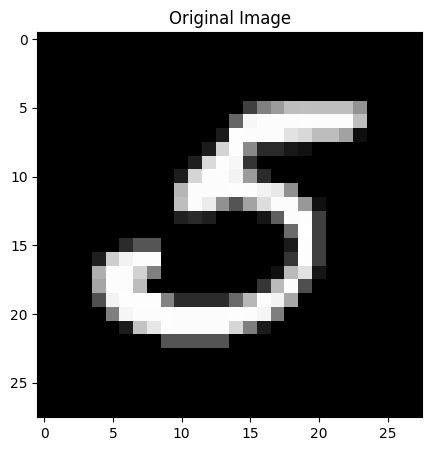

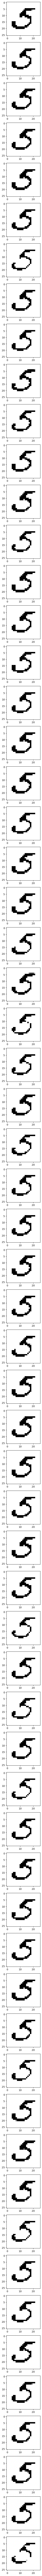

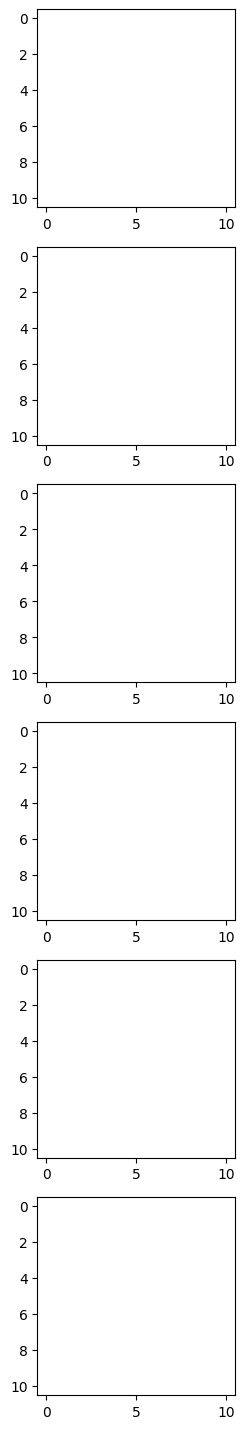

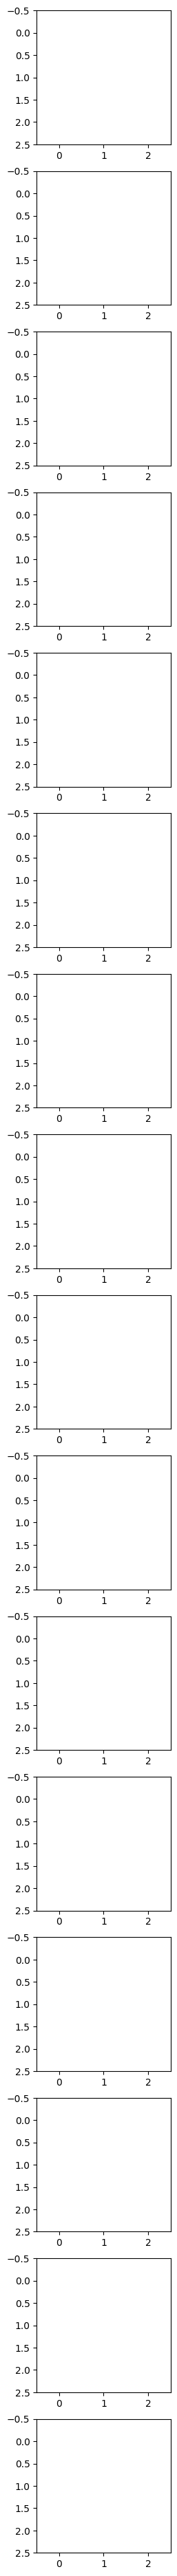

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import math

# Define the Product Unit Convolutional Layer without padding
class ProductConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1):
        super(ProductConv2d, self).__init__()
        self.weights = nn.Parameter(torch.Tensor(out_channels, in_channels, kernel_size, kernel_size))
        self.stride = stride
        nn.init.kaiming_uniform_(self.weights, a=math.sqrt(5))

    def forward(self, x):
        unfolded = F.unfold(x, kernel_size=self.weights.shape[2:], stride=self.stride)
        unfolded = unfolded.view(x.size(0), x.size(1) * self.weights.shape[2] * self.weights.shape[3], -1)
        log_unfolded = torch.log(torch.abs(unfolded) + 1e-10)
        log_weights = torch.log(torch.abs(self.weights) + 1e-10).view(self.weights.size(0), -1)
        log_product = torch.matmul(log_weights, log_unfolded)
        return torch.exp(log_product).view(x.size(0), self.weights.size(0), x.size(2) - self.weights.shape[2] + 1, x.size(3) - self.weights.shape[3] + 1)

# Define the combined CNN model without padding
class CombinedCNN(nn.Module):
    def __init__(self):
        super(CombinedCNN, self).__init__()
        self.product_conv1 = ProductConv2d(1, 64, kernel_size=3)
        self.product_conv2 = ProductConv2d(64, 64, kernel_size=3)

        self.sigma_conv1 = nn.Conv2d(64, 6, 3)  # Changed kernel size to 3 to avoid size issues
        self.pool = nn.MaxPool2d(2, 2)
        self.sigma_conv2 = nn.Conv2d(6, 16, 3)  # Changed kernel size to 3 to avoid size issues

        self.fc1 = nn.Linear(16 * 1 * 1, 120)  # Adjusted input size for fully connected layer
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.product_conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)

        # x = self.product_conv2(x)
        # x = F.relu(x)
        # x = F.max_pool2d(x, 2)

        x = F.relu(self.sigma_conv1(x))
        x = self.pool(x)

        x = F.relu(self.sigma_conv2(x))
        x = self.pool(x)

        # Ensure the input size is large enough for the fully connected layer
        if x.size(2) < 1 or x.size(3) < 1:
            raise RuntimeError(f"Input size too small for fully connected layer: {x.size()}")

        # Calculate the dynamic size for the fully connected layer
        x_size = x.size(1) * x.size(2) * x.size(3)

        x = x.view(-1, x_size)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

# Load the MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
mnist_data = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
data_loader = torch.utils.data.DataLoader(mnist_data, batch_size=1, shuffle=True)

# Initialize the model and set it to evaluation mode
model = CombinedCNN()
model.eval()

# Get a batch of images from the data loader
data_iter = iter(data_loader)
images, labels = next(data_iter)

# Register forward hooks for feature map visualization
activation = {}

def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

model.product_conv1.register_forward_hook(get_activation('product_conv1'))
# model.product_conv2.register_forward_hook(get_activation('product_conv2'))
model.sigma_conv1.register_forward_hook(get_activation('sigma_conv1'))
model.sigma_conv2.register_forward_hook(get_activation('sigma_conv2'))

# Pass an image through the model to capture activations
output = model(images)

# Visualize the original image
plt.figure(figsize=(5, 5))
plt.imshow(images[0][0], cmap='gray')
plt.title('Original Image')
plt.show()

# Visualize the feature maps
def plot_activation(activation, layer_name):
    act = activation[layer_name].squeeze()
    fig, axarr = plt.subplots(act.size(0), figsize=(15, act.size(0) * 3))
    for idx in range(act.size(0)):
        axarr[idx].imshow(act[idx].cpu().numpy(), cmap='gray')
    plt.show()

plot_activation(activation, 'product_conv1')
# plot_activation(activation, 'product_conv2')
plot_activation(activation, 'sigma_conv1')
plot_activation(activation, 'sigma_conv2')
